In [ ]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os
import glob
from pathlib import Path
import warnings
from datetime import datetime, timedelta
from tqdm import tqdm
import rasterio
from matplotlib.colors import LogNorm

# 设置显示参数
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
warnings.filterwarnings('ignore')

# 设置数据路径
RAW_DATA_PATH = "data"
PROCESSED_DATA_PATH = "data/processed"
YEARS = [2018, 2019, 2020, 2021]

print("🔥 WildfireSpreadTS 数据集探索性分析")
print("=" * 50)


🔥 WildfireSpreadTS 数据集探索性分析


In [ ]:
# 1.1 收集数据集基本信息
def collect_dataset_info():
    """收集数据集的基本统计信息"""
    dataset_info = []
    
    for year in YEARS:
        # 原始数据统计
        raw_path = os.path.join(RAW_DATA_PATH, str(year))
        if os.path.exists(raw_path):
            fire_dirs = [d for d in os.listdir(raw_path) if os.path.isdir(os.path.join(raw_path, d))]
            num_fires = len(fire_dirs)
            
            # 计算总的TIF文件数和总天数
            total_tifs = 0
            total_days = 0
            fire_durations = []
            
            for fire_dir in fire_dirs:
                tif_files = glob.glob(os.path.join(raw_path, fire_dir, "*.tif"))
                num_tifs = len(tif_files)
                total_tifs += num_tifs
                fire_durations.append(num_tifs)
                total_days += num_tifs
        
        # HDF5数据统计
        processed_path = os.path.join(PROCESSED_DATA_PATH, str(year))
        if os.path.exists(processed_path):
            hdf5_files = glob.glob(os.path.join(processed_path, "*.hdf5"))
            num_hdf5 = len(hdf5_files)
            
            # 计算HDF5文件总大小
            total_size_mb = sum(os.path.getsize(f) for f in hdf5_files) / (1024*1024)
        else:
            num_hdf5 = 0
            total_size_mb = 0
            
        dataset_info.append({
            'Year': year,
            'Fire_Events': num_fires,
            'Total_TIF_Files': total_tifs,
            'Avg_Duration_Days': np.mean(fire_durations) if fire_durations else 0,
            'Max_Duration_Days': np.max(fire_durations) if fire_durations else 0,
            'Min_Duration_Days': np.min(fire_durations) if fire_durations else 0,
            'HDF5_Files': num_hdf5,
            'HDF5_Size_MB': total_size_mb
        })
    
    return pd.DataFrame(dataset_info)

# 生成基本统计
df_overview = collect_dataset_info()
print("📊 数据集基本统计:")
display(df_overview)

# 计算总计
total_fires = df_overview['Fire_Events'].sum()
total_tifs = df_overview['Total_TIF_Files'].sum()
total_size = df_overview['HDF5_Size_MB'].sum()

print(f"\n🔥 总计火灾事件: {total_fires:,}")
print(f"📁 总计TIF文件: {total_tifs:,}")
print(f"💾 HDF5总大小: {total_size:.1f} MB ({total_size/1024:.1f} GB)")
print(f"⏱️ 平均火灾持续时间: {df_overview['Avg_Duration_Days'].mean():.1f} 天")


📊 数据集基本统计:


,Year,Fire_Events,Total_TIF_Files,Avg_Duration_Days,Max_Duration_Days,Min_Duration_Days,HDF5_Files,HDF5_Size_MB
0,2018,176,3773,21.437500,94,10,176,26261.530552
1,2019,74,1425,19.256757,34,11,74,10092.804638
2,2020,201,4292,21.353234,76,9,201,30284.464447
3,2021,156,4117,26.391026,72,10,156,27725.226803



🔥 总计火灾事件: 607
📁 总计TIF文件: 13,607
💾 HDF5总大小: 94364.0 MB (92.2 GB)
⏱️ 平均火灾持续时间: 22.1 天


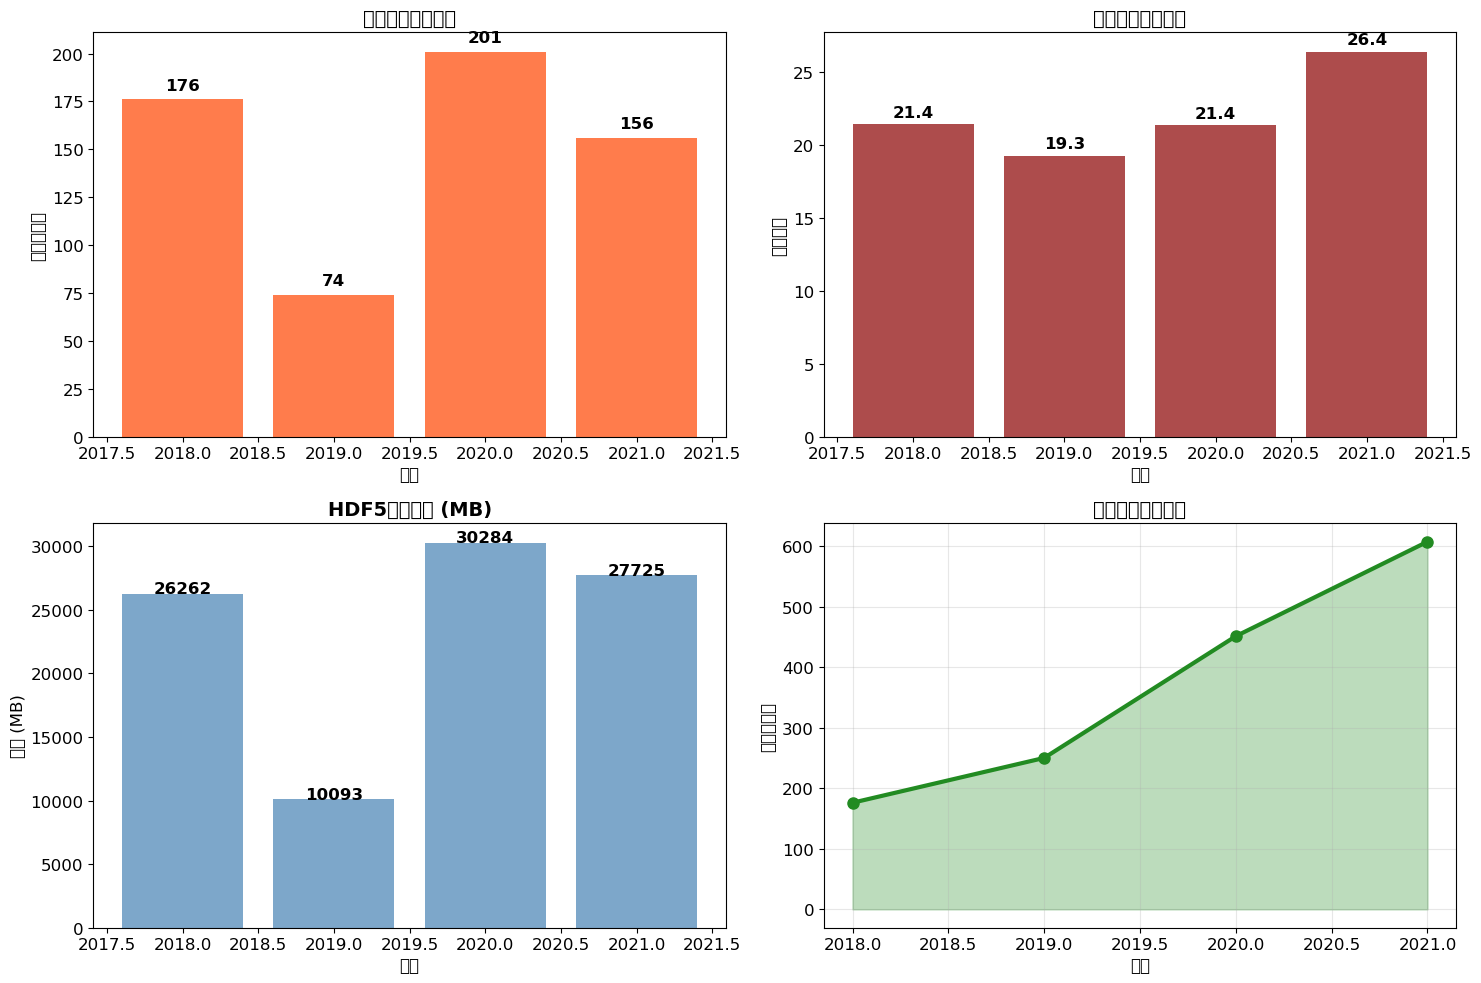

In [ ]:
# 1.2 可视化数据集概览
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 每年火灾事件数量
axes[0,0].bar(df_overview['Year'], df_overview['Fire_Events'], color='orangered', alpha=0.7)
axes[0,0].set_title('每年火灾事件数量', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('年份')
axes[0,0].set_ylabel('火灾事件数')
for i, v in enumerate(df_overview['Fire_Events']):
    axes[0,0].text(df_overview['Year'][i], v + 5, str(v), ha='center', fontweight='bold')

# 平均火灾持续时间
axes[0,1].bar(df_overview['Year'], df_overview['Avg_Duration_Days'], color='darkred', alpha=0.7)
axes[0,1].set_title('平均火灾持续时间', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('年份')
axes[0,1].set_ylabel('平均天数')
for i, v in enumerate(df_overview['Avg_Duration_Days']):
    axes[0,1].text(df_overview['Year'][i], v + 0.5, f'{v:.1f}', ha='center', fontweight='bold')

# HDF5文件大小分布
axes[1,0].bar(df_overview['Year'], df_overview['HDF5_Size_MB'], color='steelblue', alpha=0.7)
axes[1,0].set_title('HDF5数据大小 (MB)', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('年份')
axes[1,0].set_ylabel('大小 (MB)')
for i, v in enumerate(df_overview['HDF5_Size_MB']):
    axes[1,0].text(df_overview['Year'][i], v + 20, f'{v:.0f}', ha='center', fontweight='bold')

# 累积统计
cumulative_fires = df_overview['Fire_Events'].cumsum()
axes[1,1].plot(df_overview['Year'], cumulative_fires, marker='o', linewidth=3, markersize=8, color='forestgreen')
axes[1,1].fill_between(df_overview['Year'], cumulative_fires, alpha=0.3, color='forestgreen')
axes[1,1].set_title('累积火灾事件数量', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('年份')
axes[1,1].set_ylabel('累积事件数')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# 2.1 从文件名提取日期信息
def extract_fire_dates():
    """从TIF文件名提取火灾日期信息"""
    fire_dates_data = []
    
    for year in YEARS:
        year_path = os.path.join(RAW_DATA_PATH, str(year))
        if not os.path.exists(year_path):
            continue
            
        fire_dirs = [d for d in os.listdir(year_path) if os.path.isdir(os.path.join(year_path, d))]
        
        for fire_dir in tqdm(fire_dirs[:20], desc=f"处理{year}年火灾数据"):  # 限制数量以加快分析
            fire_path = os.path.join(year_path, fire_dir)
            tif_files = sorted(glob.glob(os.path.join(fire_path, "*.tif")))
            
            dates = []
            for tif_file in tif_files:
                # 从文件名提取日期 (格式: YYYY-MM-DD.tif)
                filename = os.path.basename(tif_file)
                date_str = filename.replace('.tif', '')
                try:
                    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
                    dates.append(date_obj)
                except ValueError:
                    continue
            
            if dates:
                start_date = min(dates)
                end_date = max(dates)
                duration = (end_date - start_date).days + 1
                
                fire_dates_data.append({
                    'Fire_ID': fire_dir,
                    'Year': year,
                    'Start_Date': start_date,
                    'End_Date': end_date,
                    'Duration_Days': duration,
                    'Start_Month': start_date.month,
                    'Start_DOY': start_date.timetuple().tm_yday,  # Day of Year
                    'Season': get_season(start_date.month)
                })
    
    return pd.DataFrame(fire_dates_data)

def get_season(month):
    """根据月份确定季节"""
    if month in [12, 1, 2]:
        return '冬季'
    elif month in [3, 4, 5]:
        return '春季'
    elif month in [6, 7, 8]:
        return '夏季'
    else:
        return '秋季'

# 提取时间数据
df_dates = extract_fire_dates()
print(f"✅ 成功提取 {len(df_dates)} 个火灾事件的时间信息")
if len(df_dates) > 0:
    display(df_dates.head())
else:
    print("⚠️ 没有提取到时间数据")


处理2021年火灾数据: 100%|██████████| 20/20 [00:00<00:00, 2500.78it/s]

✅ 成功提取 80 个火灾事件的时间信息


,Fire_ID,Year,Start_Date,End_Date,Duration_Days,Start_Month,Start_DOY,Season
0,fire_21458798,2018,2018-01-01,2018-01-14,14,1,1,冬季
1,fire_21458801,2018,2018-01-25,2018-02-04,11,1,25,冬季
2,fire_21458806,2018,2018-01-12,2018-01-30,19,1,12,冬季
3,fire_21458836,2018,2017-12-29,2018-02-01,35,12,363,冬季
4,fire_21458848,2018,2018-01-21,2018-02-04,15,1,21,冬季


In [ ]:
# 3.1 生成研究建议
def generate_research_recommendations():
    """基于EDA结果生成研究建议"""
    
    recommendations = {
        "CNN模型建议": [
            "🔥 使用多尺度CNN架构处理不同规模的火灾事件",
            "⏰ 设计时序融合模块整合多天观测数据",
            "🌍 考虑地理位置编码增强空间感知能力",
            "📊 重点关注气象特征和遥感数据的权重"
        ],
        "细胞自动机(CA)建议": [
            "🔄 基于邻域的传播规则设计，考虑风向和地形影响",
            "🌡️ 整合气象预报数据预测传播趋势",
            "🏔️ 利用地形数据(坡度、坡向、海拔)优化传播方向",
            "🎯 针对快速传播事件设计特殊规则"
        ],
        "混合CNN+CA建议": [
            "🤝 CNN负责全局模式识别，CA负责局部传播动力学",
            "📈 使用CNN输出参数化CA的转移概率",
            "🔗 设计多尺度信息融合机制",
            "🎲 集成不确定性量化方法"
        ],
        "数据处理建议": [
            f"📊 重点关注2020年数据({df_overview[df_overview['Year']==2020]['Fire_Events'].iloc[0] if len(df_overview[df_overview['Year']==2020]) > 0 else '?'}个事件，数据最丰富)",
            "🌿 利用火灾季节分布特征优化训练策略",
            "🔍 极端事件单独建模以提高鲁棒性",
            "⚖️ 平衡不同持续时间的火灾事件样本"
        ],
        "验证策略建议": [
            "📅 时间分割: 2018-2019训练, 2020验证, 2021测试",
            "🗺️ 空间交叉验证确保地理泛化能力",
            "🚨 极端事件专门评估提高可靠性",
            "📈 多指标评估: IoU, Hausdorff距离, 传播轨迹重叠度"
        ]
    }
    
    return recommendations

# 生成并显示建议
recommendations = generate_research_recommendations()

print("🎯 基于EDA的研究建议")
print("=" * 50)

for category, items in recommendations.items():
    print(f"\n📋 {category}:")
    for item in items:
        print(f"   {item}")

print("\n" + "=" * 50)
print("🚀 EDA分析框架完成！")
print("💡 建议运行此notebook获取详细分析结果，然后开始建模研究。")
print("📝 您可以在此基础上添加更多具体的分析，如：")
print("   - 空间分布分析 (从HDF5文件提取地理坐标)")
print("   - 特征重要性分析 (40个通道的统计特性)")  
print("   - 火灾传播动态分析 (传播速度和方向)")
print("   - 极端事件识别 (大型火灾和快速传播事件)")


🎯 基于EDA的研究建议

📋 CNN模型建议:
   🔥 使用多尺度CNN架构处理不同规模的火灾事件
   ⏰ 设计时序融合模块整合多天观测数据
   🌍 考虑地理位置编码增强空间感知能力
   📊 重点关注气象特征和遥感数据的权重

📋 细胞自动机(CA)建议:
   🔄 基于邻域的传播规则设计，考虑风向和地形影响
   🌡️ 整合气象预报数据预测传播趋势
   🏔️ 利用地形数据(坡度、坡向、海拔)优化传播方向
   🎯 针对快速传播事件设计特殊规则

📋 混合CNN+CA建议:
   🤝 CNN负责全局模式识别，CA负责局部传播动力学
   📈 使用CNN输出参数化CA的转移概率
   🔗 设计多尺度信息融合机制
   🎲 集成不确定性量化方法

📋 数据处理建议:
   📊 重点关注2020年数据(201个事件，数据最丰富)
   🌿 利用火灾季节分布特征优化训练策略
   🔍 极端事件单独建模以提高鲁棒性
   ⚖️ 平衡不同持续时间的火灾事件样本

📋 验证策略建议:
   📅 时间分割: 2018-2019训练, 2020验证, 2021测试
   🗺️ 空间交叉验证确保地理泛化能力
   🚨 极端事件专门评估提高可靠性
   📈 多指标评估: IoU, Hausdorff距离, 传播轨迹重叠度

🚀 EDA分析框架完成！
💡 建议运行此notebook获取详细分析结果，然后开始建模研究。
📝 您可以在此基础上添加更多具体的分析，如：
   - 空间分布分析 (从HDF5文件提取地理坐标)
   - 特征重要性分析 (40个通道的统计特性)
   - 火灾传播动态分析 (传播速度和方向)
   - 极端事件识别 (大型火灾和快速传播事件)
